In [ ]:
from google.colab import files
uploaded = files.upload()  # Upload your dataset

import pandas as pd
file_name = list(uploaded.keys())[0]  # Automatically retrieve uploaded filename
data = pd.read_csv(file_name)

Saving Driving Data(KIA SOUL)_(150728-160714)_(10 Drivers_A-J).csv to Driving Data(KIA SOUL)_(150728-160714)_(10 Drivers_A-J).csv


In [ ]:
# Install necessary libraries if not already installed (Optional)
# !pip install torch torchvision

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np

# Load the dataset (use uploaded file or modify this to your dataset location)
file_name = "Driving Data(KIA SOUL).csv"  # Replace with your file name if needed
#data = pd.read_csv(file_name)

# Select relevant features
selected_features = [
    "Throttle_position_signal",
    "Absolute_throttle_position",
    "Acceleration_speed_-_Longitudinal",
    "Acceleration_speed_-_Lateral",
    "Steering_wheel_angle",
    "Steering_wheel_speed",
    "Indication_of_brake_switch_ON/OFF",
    "Master_cylinder_pressure",
]

filtered_data = data[selected_features]

# Normalize the features
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(filtered_data)
normalized_df = pd.DataFrame(normalized_data, columns=selected_features)

# Define the base distribution
class BaseDistribution(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.base_dist = torch.distributions.MultivariateNormal(
            loc=torch.zeros(input_dim),
            covariance_matrix=torch.eye(input_dim)
        )

    def sample(self, num_samples):
        return self.base_dist.sample((num_samples,))

    def log_prob(self, x):
        return self.base_dist.log_prob(x)

# Define Affine Coupling Layer
class AffineCoupling(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.scale_net = nn.Sequential(
            nn.Linear(input_dim // 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim // 2),
            nn.Tanh()
        )
        self.translation_net = nn.Sequential(
            nn.Linear(input_dim // 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim // 2)
        )

    def forward(self, x, direction):
        x1, x2 = x.chunk(2, dim=-1)
        if direction == "forward":
            scale = self.scale_net(x1)
            translation = self.translation_net(x1)
            z2 = x2 * torch.exp(scale) + translation
            z = torch.cat([x1, z2], dim=-1)
            log_det_jacobian = scale.sum(dim=-1)
            return z, log_det_jacobian
        elif direction == "inverse":
            scale = self.scale_net(x1)
            translation = self.translation_net(x1)
            x2 = (x2 - translation) * torch.exp(-scale)
            x = torch.cat([x1, x2], dim=-1)
            log_det_jacobian = -scale.sum(dim=-1)
            return x, log_det_jacobian

# RealNVP Model
class RealNVP(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_flows):
        super().__init__()
        self.flows = nn.ModuleList([AffineCoupling(input_dim, hidden_dim) for _ in range(num_flows)])
        self.base_distribution = BaseDistribution(input_dim)

    def forward(self, x):
        z = x
        log_det_jacobian = 0
        for flow in self.flows:
            z, ldj = flow(z, "forward")
            log_det_jacobian += ldj
        log_prob = self.base_distribution.log_prob(z) + log_det_jacobian
        return log_prob

    def inverse(self, z):
        x = z
        for flow in reversed(self.flows):
            x, _ = flow(x, "inverse")
        return x

# Initialize model
input_dim = normalized_df.shape[1]
hidden_dim = 64
num_flows = 4

model = RealNVP(input_dim, hidden_dim, num_flows)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Convert data to PyTorch tensor
data_tensor = torch.tensor(normalized_df.values, dtype=torch.float32)

# Training loop
epochs = 50
batch_size = 128

for epoch in range(epochs):
    model.train()
    permutation = torch.randperm(data_tensor.size(0))
    for i in range(0, data_tensor.size(0), batch_size):
        optimizer.zero_grad()
        batch_indices = permutation[i:i + batch_size]
        batch = data_tensor[batch_indices]
        loss = -model(batch).mean()  # Negative log-likelihood
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}")

# Anomaly scoring
with torch.no_grad():
    model.eval()
    log_likelihood = model(data_tensor)
    anomaly_scores = -log_likelihood.numpy()

# Identify top anomalies
anomaly_indices = np.argsort(anomaly_scores)[-10:]  # Top 10 anomalies
print("Top 10 Anomalous Points:")
print(normalized_df.iloc[anomaly_indices])


Epoch 1/50, Loss: -3.4252541065216064
Epoch 2/50, Loss: -3.2601943016052246
Epoch 3/50, Loss: -2.106356143951416
Epoch 4/50, Loss: -1.7345290184020996
Epoch 5/50, Loss: -3.378641366958618
Epoch 6/50, Loss: -2.556466817855835
Epoch 7/50, Loss: -2.6258561611175537
Epoch 8/50, Loss: -2.288522243499756
Epoch 9/50, Loss: -3.6189699172973633
Epoch 10/50, Loss: -3.193626642227173
Epoch 11/50, Loss: -4.275585174560547
Epoch 12/50, Loss: -3.1905057430267334
Epoch 13/50, Loss: -3.8073174953460693
Epoch 14/50, Loss: -2.6500093936920166
Epoch 15/50, Loss: -3.937913417816162
Epoch 16/50, Loss: -3.720444679260254
Epoch 17/50, Loss: -3.9393606185913086
Epoch 18/50, Loss: -4.348532199859619
Epoch 19/50, Loss: -2.3380892276763916
Epoch 20/50, Loss: -4.119778633117676
Epoch 21/50, Loss: -3.332369089126587
Epoch 22/50, Loss: -2.1568374633789062
Epoch 23/50, Loss: -4.447267055511475
Epoch 24/50, Loss: -2.532074213027954
Epoch 25/50, Loss: -3.432347059249878
Epoch 26/50, Loss: -3.888241767883301
Epoch 27/5

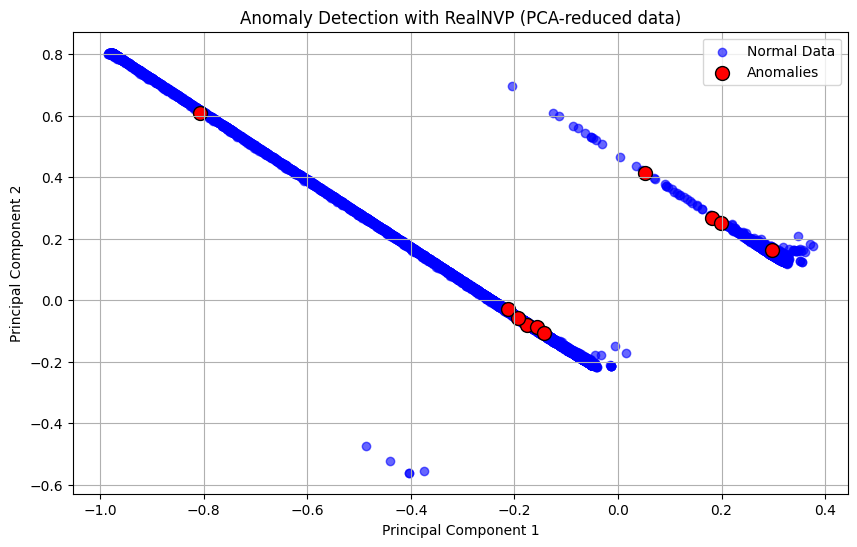

In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

# Dimensionality reduction using PCA
pca = PCA(n_components=2)  # Reducing to 2 dimensions for visualization
reduced_data = pca.fit_transform(normalized_df.values)

plt.figure(figsize=(10, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], label="Normal Data", alpha=0.6, color="blue")
plt.scatter(
    reduced_data[anomaly_indices, 0],
    reduced_data[anomaly_indices, 1],
    color='red',
    label="Anomalies",
    edgecolor='k',
    s=100,
)
plt.title("Anomaly Detection with RealNVP (PCA-reduced data)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)
plt.show()


**Isolation Forest**

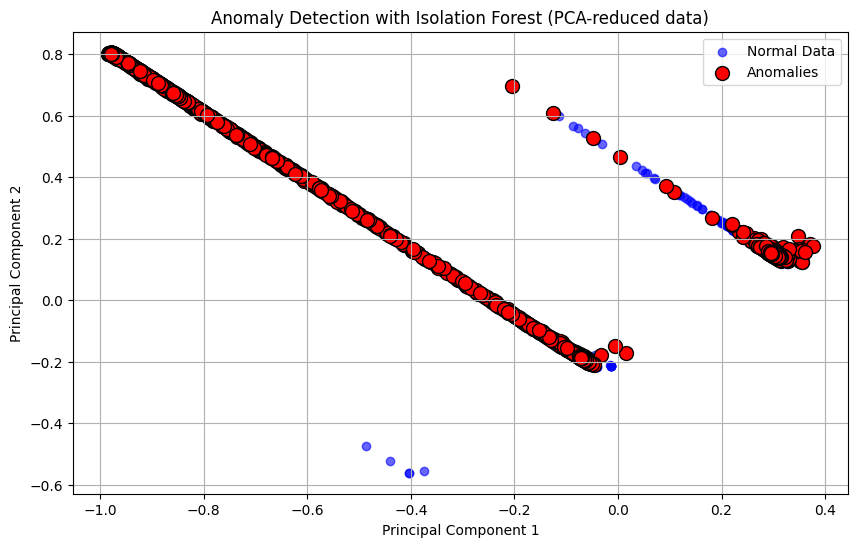

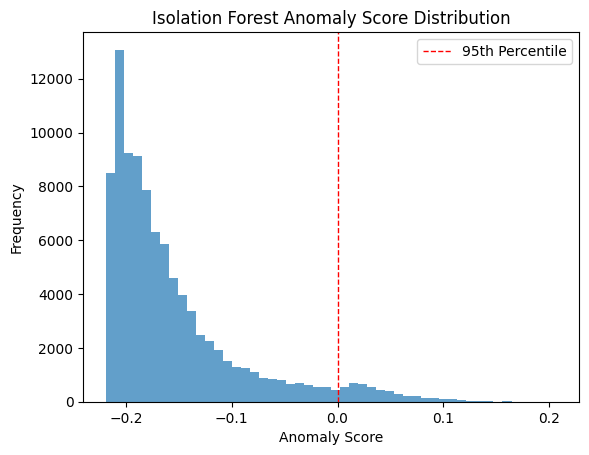

In [ ]:
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import numpy as np

scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(filtered_data)  # Assume filtered_data is defined
normalized_df = pd.DataFrame(normalized_data, columns=selected_features)

# Dimensionality reduction using PCA
pca = PCA(n_components=2)  # Reducing to 2 dimensions for visualization
reduced_data = pca.fit_transform(normalized_df.values)

# Define Isolation Forest model
iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)

# Fit the model
iso_forest.fit(normalized_df)

# Get predictions and anomaly scores
iso_forest_predictions = iso_forest.predict(normalized_df)
iso_forest_scores = -iso_forest.decision_function(normalized_df)

# Visualization
plt.figure(figsize=(10, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], label="Normal Data", alpha=0.6, color="blue")
anomaly_indices = np.where(iso_forest_predictions == -1)[0]
plt.scatter(
    reduced_data[anomaly_indices, 0],
    reduced_data[anomaly_indices, 1],
    color='red',
    label="Anomalies",
    edgecolor='k',
    s=100,
)
plt.title("Anomaly Detection with Isolation Forest (PCA-reduced data)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)
plt.show()

plt.hist(iso_forest_scores, bins=50, alpha=0.7)
plt.title("Isolation Forest Anomaly Score Distribution")
plt.xlabel("Anomaly Score")
plt.ylabel("Frequency")
plt.axvline(np.percentile(iso_forest_scores, 95), color='red', linestyle='dashed', linewidth=1, label="95th Percentile")
plt.legend()
plt.show()


**One class SVM**

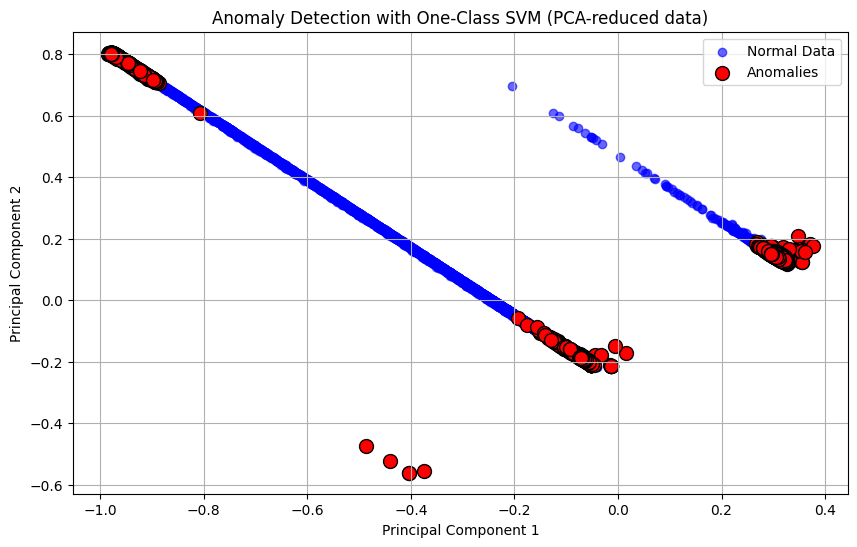

In [ ]:
from sklearn.svm import OneClassSVM

scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(filtered_data)  # Assume filtered_data is defined
normalized_df = pd.DataFrame(normalized_data, columns=selected_features)

# Dimensionality reduction using PCA
pca = PCA(n_components=2)  # Reducing to 2 dimensions for visualization
reduced_data = pca.fit_transform(normalized_df.values)

# Define One-Class SVM model
oc_svm = OneClassSVM(kernel="rbf", gamma=0.1, nu=0.05)

# Fit the model
oc_svm.fit(normalized_df)

# Get predictions and anomaly scores
oc_svm_predictions = oc_svm.predict(normalized_df)
oc_svm_scores = -oc_svm.decision_function(normalized_df)

# Visualization
plt.figure(figsize=(10, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], label="Normal Data", alpha=0.6, color="blue")
anomaly_indices = np.where(oc_svm_predictions == -1)[0]
plt.scatter(
    reduced_data[anomaly_indices, 0],
    reduced_data[anomaly_indices, 1],
    color='red',
    label="Anomalies",
    edgecolor='k',
    s=100,
)
plt.title("Anomaly Detection with One-Class SVM (PCA-reduced data)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)
plt.show()

**Autoencoder**

Epoch 1/100, Loss: 0.000206
Epoch 2/100, Loss: 0.000060
Epoch 3/100, Loss: 0.000039
Epoch 4/100, Loss: 0.000030
Epoch 5/100, Loss: 0.000025
Epoch 6/100, Loss: 0.000022
Epoch 7/100, Loss: 0.000019
Epoch 8/100, Loss: 0.000018
Epoch 9/100, Loss: 0.000018
Epoch 10/100, Loss: 0.000018
Epoch 11/100, Loss: 0.000017
Epoch 12/100, Loss: 0.000017
Epoch 13/100, Loss: 0.000018
Epoch 14/100, Loss: 0.000017
Epoch 15/100, Loss: 0.000017
Epoch 16/100, Loss: 0.000017
Epoch 17/100, Loss: 0.000017
Epoch 18/100, Loss: 0.000017
Epoch 19/100, Loss: 0.000017
Epoch 20/100, Loss: 0.000017
Epoch 21/100, Loss: 0.000017
Epoch 22/100, Loss: 0.000017
Epoch 23/100, Loss: 0.000017
Epoch 24/100, Loss: 0.000017
Epoch 25/100, Loss: 0.000017
Epoch 26/100, Loss: 0.000017
Epoch 27/100, Loss: 0.000017
Epoch 28/100, Loss: 0.000017
Epoch 29/100, Loss: 0.000017
Epoch 30/100, Loss: 0.000016
Epoch 31/100, Loss: 0.000016
Epoch 32/100, Loss: 0.000017
Epoch 33/100, Loss: 0.000017
Epoch 34/100, Loss: 0.000016
Epoch 35/100, Loss: 0.0

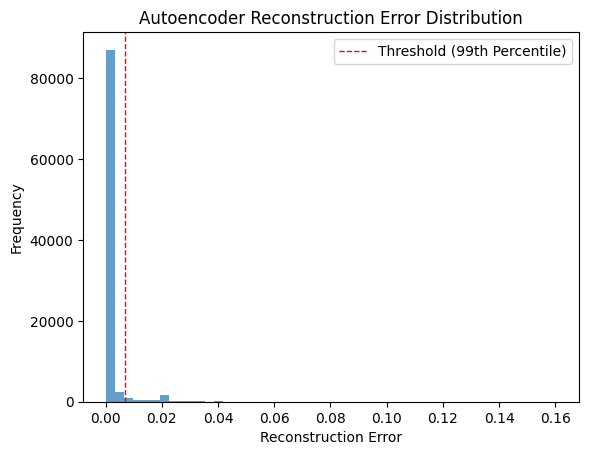

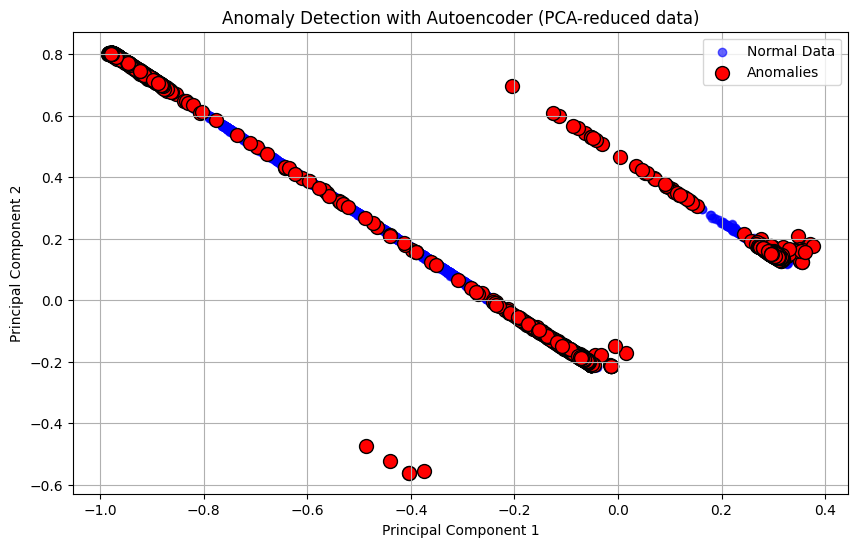

In [ ]:
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(filtered_data)  # Assume filtered_data is defined
normalized_df = pd.DataFrame(normalized_data, columns=selected_features)

# Dimensionality reduction using PCA
pca = PCA(n_components=2)  # Reducing to 2 dimensions for visualization
reduced_data = pca.fit_transform(normalized_df.values)

# Define Autoencoder architecture
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Dropout(p=0.2),  # Dropout added here
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Dropout(p=0.2),  # Dropout added here
            nn.Linear(8, 2)  # Bottleneck
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 8),
            nn.ReLU(),
            nn.Dropout(p=0.2),  # Dropout added here
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Dropout(p=0.2),  # Dropout added here
            nn.Linear(16, input_dim),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Initialize Autoencoder
input_dim = normalized_df.shape[1]
autoencoder = Autoencoder(input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)

# Convert data to PyTorch tensor
data_tensor = torch.tensor(normalized_df.values, dtype=torch.float32)

# Train the Autoencoder
epochs = 100
batch_size = 128

for epoch in range(epochs):
    autoencoder.train()
    epoch_loss = 0
    for i in range(0, len(data_tensor), batch_size):
        batch = data_tensor[i:i + batch_size]
        optimizer.zero_grad()
        outputs = autoencoder(batch)
        loss = criterion(outputs, batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss / len(data_tensor):.6f}")

# Compute reconstruction error
autoencoder.eval()
with torch.no_grad():
    reconstructed = autoencoder(data_tensor).numpy()
    reconstruction_error = np.mean((normalized_df.values - reconstructed) ** 2, axis=1)

# Identify anomalies based on reconstruction error
threshold = np.percentile(reconstruction_error, 95)  # Top 5% errors
anomaly_indices = np.where(reconstruction_error > threshold)[0]
autoencoder_predictions = np.where(reconstruction_error > threshold, -1, 1)

# Visualize reconstruction error distribution
plt.hist(reconstruction_error, bins=50, alpha=0.7)
plt.title("Autoencoder Reconstruction Error Distribution")
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.axvline(threshold, color='red', linestyle='dashed', linewidth=1, label="Threshold (99th Percentile)")
plt.legend()
plt.show()

# Visualization
plt.figure(figsize=(10, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], label="Normal Data", alpha=0.6, color="blue")
plt.scatter(
    reduced_data[anomaly_indices, 0],
    reduced_data[anomaly_indices, 1],
    color='red',
    label="Anomalies",
    edgecolor='k',
    s=100,
)
plt.title("Anomaly Detection with Autoencoder (PCA-reduced data)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)
plt.show()





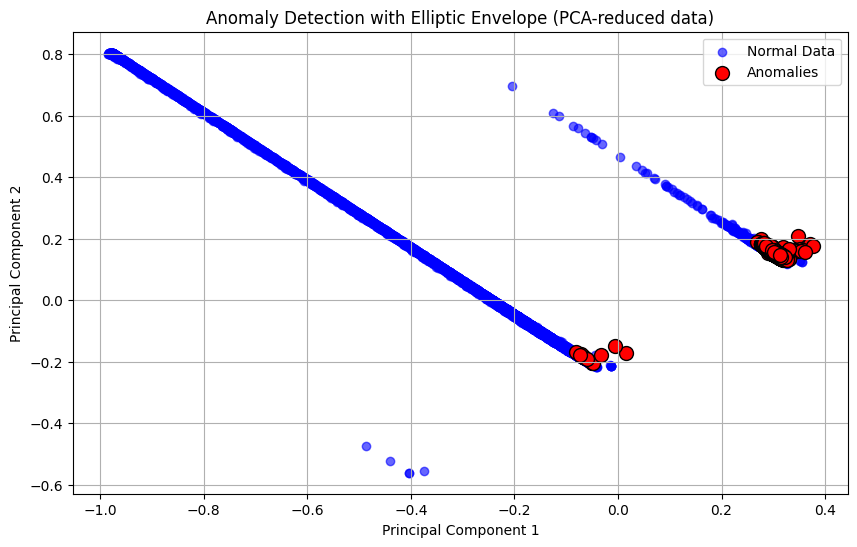

Number of anomalies detected: 4718


In [ ]:
from sklearn.covariance import EllipticEnvelope

# Normalize the dataset
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(filtered_data)
normalized_df = pd.DataFrame(normalized_data, columns=selected_features)

# Dimensionality reduction using PCA for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(normalized_df.values)


# Initialize the Elliptic Envelope
elliptic_model = EllipticEnvelope(contamination=0.05, random_state=42)

# Fit the model
elliptic_model.fit(normalized_df)

# Predict anomalies
elliptic_predictions = elliptic_model.predict(normalized_df)  # -1 = anomaly, 1 = normal
elliptic_scores = -elliptic_model.decision_function(normalized_df)  # Higher scores = more anomalous

# Visualize anomalies in PCA-reduced space
plt.figure(figsize=(10, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], label="Normal Data", alpha=0.6, color="blue")
anomaly_indices = np.where(elliptic_predictions == -1)[0]
plt.scatter(
    reduced_data[anomaly_indices, 0],
    reduced_data[anomaly_indices, 1],
    color='red',
    label="Anomalies",
    edgecolor='k',
    s=100,
)
plt.title("Anomaly Detection with Elliptic Envelope (PCA-reduced data)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)
plt.show()

# Print summary
print(f"Number of anomalies detected: {len(anomaly_indices)}")


**evaluation**

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score

# Simulate Ground Truth Labels (Optional Step)
# Replace this with real ground truth labels if available.
np.random.seed(42)
ground_truth = np.random.choice([1, -1], size=len(normalized_df), p=[0.95, 0.05])

# Function to Evaluate a Method
def evaluate_method(predictions, scores, method_name):
    # Calculate Precision, Recall, F1-Score
    precision, recall, f1, _ = precision_recall_fscore_support(
        ground_truth, predictions, average="binary", pos_label=-1
    )
    # Calculate ROC-AUC
    roc_auc = roc_auc_score(ground_truth, scores)

    print(f"\nEvaluation Metrics for {method_name}:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC-AUC:   {roc_auc:.4f}")
    return precision, recall, f1, roc_auc

# 1. Isolation Forest
iso_forest_predictions = iso_forest.predict(normalized_df)
iso_forest_scores = -iso_forest.decision_function(normalized_df)
evaluate_method(iso_forest_predictions, iso_forest_scores, "Isolation Forest")

# 2. One-Class SVM
oc_svm_scores = -oc_svm.decision_function(normalized_df)
evaluate_method(oc_svm_predictions, oc_svm_scores, "One-Class SVM")

# 3. Autoencoder
autoencoder_predictions = np.where(reconstruction_error > threshold, -1, 1)
evaluate_method(autoencoder_predictions, reconstruction_error, "Autoencoder")

# 4. Normalizing Flow
with torch.no_grad():
    model.eval()
    log_likelihood = model(data_tensor)
    nf_scores = -log_likelihood.numpy()  # Higher negative log-likelihood = more anomalous

# Convert scores to binary predictions (e.g., top 5% as anomalies)
nf_threshold = np.percentile(nf_scores, 95)  # Top 5% threshold
nf_predictions = np.where(nf_scores > nf_threshold, -1, 1)

evaluate_method(nf_predictions, nf_scores, "Normalizing Flow")

# 5.
evaluate_method(elliptic_predictions, elliptic_scores, "elliptic")



Evaluation Metrics for Isolation Forest:
Precision: 0.0460
Recall:    0.0474
F1-Score: 0.0467
ROC-AUC:   0.5006

Evaluation Metrics for One-Class SVM:
Precision: 0.0441
Recall:    0.0454
F1-Score: 0.0447
ROC-AUC:   0.5027

Evaluation Metrics for Autoencoder:
Precision: 0.0451
Recall:    0.0465
F1-Score: 0.0458
ROC-AUC:   0.5005

Evaluation Metrics for Normalizing Flow:
Precision: 0.0490
Recall:    0.0504
F1-Score: 0.0497
ROC-AUC:   0.5033

Evaluation Metrics for elliptic:
Precision: 0.0553
Recall:    0.0570
F1-Score: 0.0561
ROC-AUC:   0.4988


(0.055320050869012295,
 0.05697445972495088,
 0.05613506828691257,
 0.49882114660601284)

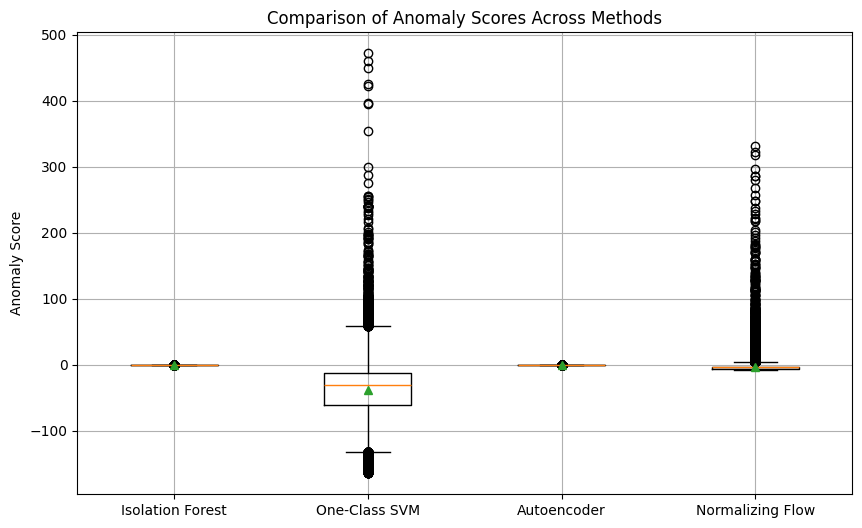

In [ ]:
# Collect anomaly scores from all methods
methods = ["Isolation Forest", "One-Class SVM", "Autoencoder", "Normalizing Flow"]
scores = [
    iso_forest_scores,  # From Isolation Forest
    oc_svm_scores,      # From One-Class SVM
    reconstruction_error,  # From Autoencoder
    nf_scores,          # From Normalizing Flow
]

# Boxplot of Anomaly Scores
plt.figure(figsize=(10, 6))
plt.boxplot(scores, labels=methods, showmeans=True)
plt.title("Comparison of Anomaly Scores Across Methods")
plt.ylabel("Anomaly Score")
plt.grid(True)
plt.show()
